# Quick and Easy Caching with KCK

Caching with KCK is simple, at least for simple processes in small codebases.  Complex pipelines with complex code are less so, but KCK's decorator interface keeps the footprint light in either case.

## easy performance gains with decorators

Originally just an afterthought, the decorator interface has proven to be an incredibly painless way to upgrade the performance and feature set of again data processing code.

First, to kick things off, we import the same code we did in the previous notebook.

In [1]:
import kck_analysis.lib.notebook_imports
import matplotlib.pyplot as plt
import kck_analysis.notebooks.stores.common
from kck_analysis.notebooks.stores.common import (
    get_heatmap_data, time_code, find_nearest_stores, db, 
    rollback_database, get_store_revenue_objects, update_revenue_object,
    clear_caches, get_revenue_percentiles_dict, np,get_store_location,
    update_queued_refreshes, hide_stderr_cells,
    GRID_X_MAX, GRID_Y_MAX, 
    NUM_STORES, YEAR_OF_INTEREST, NEIGHBOR_SEARCH_DIST
)
hide_stderr_cells()

Then, we'll define caching versions of the data updating and data retrieval functions.

In [2]:
from kck.lib.decorators import kckprime, kckrefresh

@kckprime(name='heatmap')
def caching_get_heatmap_data(revenue_dict_func=None):
    return get_heatmap_data(revenue_dict_func)

As you can see, there's not much to the developer interface.

The decorator tells KCK that the function is a primer for a cache entry generator named _heatmap_.  And it defines the key, __heatmap_data__ via which the results of running the primer can be obtained.

To the caller, this should all be transparent.

### the performance implications of caching

Both to show how easy kck is to use and to highlight the benefits of caching generally, we'll grab the data and show it as a heatmap, then ask for the same information twice more.

This is exactly the same procedure we followed in the __[previous notebook](/notebooks/notebooks/stores/no_caching.ipynb)__, except we use the decorated version of get_heatmap_data().

In [3]:
clear_caches()

with time_code():
    map_data = caching_get_heatmap_data()
plt.imshow(map_data[12], cmap='hot', interpolation='nearest')
plt.show()

execution time: 5.877


In [4]:
with time_code():
    map_data = caching_get_heatmap_data()

execution time: 0.019


In [5]:
with time_code():
    map_data = caching_get_heatmap_data()

execution time: 0.012


The first call to caching_get_heatmap_data() took roughly the same amount of time as it did in the previous notebook, but the subsequent calls returned much more quickly.

### cache invalidation

Caching makes things fast, but it's easy to serve stale data.

It's helpful to be able to say "whenever data A changes, delete the cache entry so it can be recomputed."

KCK is meant to run as a system of cooperating services, one of which is a refresh server.  So instead of simply deleting the cache entry, KCK makes it easy to keep serving the old version of the cache entry right up until the new version is available, at which point the new version becomes immediately available.

So far in this notebook, we've sped up the data fetch, but when we update data...

In [6]:
# grab the closest store to the middle of the grid
median_store_id = find_nearest_stores(int(GRID_X_MAX/2), int(GRID_Y_MAX/2))[0][0]

# update the revenues for the middle store
revenue_object_list = get_store_revenue_objects(median_store_id)
for revenue_obj in revenue_object_list:
    update_revenue_object(revenue_obj.id, revenue_obj.revenue * 5)

...nothing changes:


In [7]:
with time_code():
    map_data = caching_get_heatmap_data()
plt.imshow(map_data[12], cmap='hot', interpolation='nearest')
plt.show()

execution time: 0.008


The cache entry is still present, so the primer function doesn't get run again and the cache entry remains the same despite the update.

### the @kckrefresh decorator

Another decorator, __kckrefresh__, provides what we need to keep the cache entry in sync. 

Now we'll define a version of __update_revenue_object()__ that will instruct KCK to refresh the cache entry any time the function is called.

In [8]:
@kckrefresh(name='heatmap')
def caching_update_revenue_object(revenue_object_id, revenue):
    update_revenue_object(revenue_object_id, revenue)

Still pretty simple.

Now if we update again, we'll see that the data product is regenerated.

In [9]:
# update the revenues for the middle store
revenue_object_list = get_store_revenue_objects(median_store_id)
with time_code() as timer:
    for revenue_obj in revenue_object_list:
        caching_update_revenue_object(revenue_obj.id, revenue_obj.revenue * 5)

execution time: 57.285


execution time: 0.011


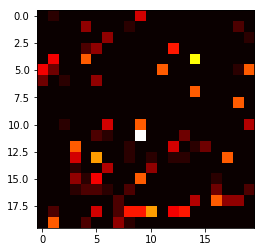

In [10]:
with time_code():
    map_data = caching_get_heatmap_data()
plt.imshow(map_data[12], cmap='hot', interpolation='nearest')
plt.show()

Note that the reported execution time for caching_get_heatmap_data() is relatively low, even with all of those updates.  This is because the refresh actually happened every time the call to caching_update_revenue_object() was made.

In this case, the number of updates is substantial, so the total time spent on the loop that updates the revenue records for the middle-most store is {{ timer.seconds() }} seconds.

### queued refresh requests

As previously mentioned, KCK was designed to run with a group of services running, one of which is the refresh server.

Generally, a request for a refresh in KCK doesn't result in an immediate refresh (although it can, if that's really what you want).  Instead, the refresh request is queued and one or more refresh workers will service the request in short order.

And, if multiple refresh requests for the same key are enqueued, the refresh worker can, in some circumstances, prioritize that refresh request over other, less heavily requested refreshes.

To show how performance is improved over the previous example in which a refresh was occurring with each update, the decorated function below is a refreshing updater that queues its refresh requests.

In [11]:
@kckrefresh(name='heatmap', queued=True)
def queued_caching_update_revenue_object(revenue_object_id, revenue):
    update_revenue_object(revenue_object_id, revenue)

So then, when we call this function as we did it's non-queuing predecessor:

In [12]:
# update the revenues for the middle store
revenue_object_list = get_store_revenue_objects(median_store_id)
with time_code() as timer:
    for revenue_obj in revenue_object_list:
        queued_caching_update_revenue_object(revenue_obj.id, revenue_obj.revenue * 5)

execution time: 0.068


The database writes were nice and fast, but the cache entry wasn't updated.

execution time: 0.017


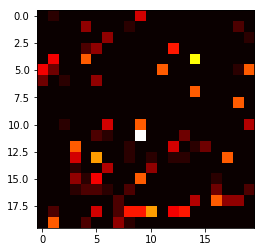

In [13]:
with time_code():
    map_data = caching_get_heatmap_data()
plt.imshow(map_data[12], cmap='hot', interpolation='nearest')
plt.show()

By calling update_queued_refreshes(), we can simulate what happens when a refresh worker performs a requested refresh:

In [14]:
with time_code():
    update_queued_refreshes()

execution time: 4.959


The execution time is what we expect for a single cache entry update.

The next call to caching_get_heatmap_data() returns updated data and it responds very quickly:

execution time: 0.011


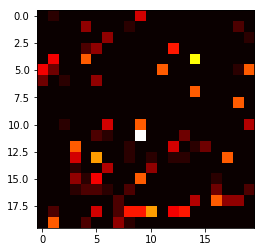

In [15]:
with time_code():
    map_data = caching_get_heatmap_data()
plt.imshow(map_data[12], cmap='hot', interpolation='nearest')
plt.show()

At this point, KCK looks like a fairly rudimentary caching solution with some neato decorators.

In the notebooks that follow, we'll explore how KCK:
- is a source-agnostic distributor of data
- rethinks data flows to achieve huge performance gains
- is a ultra-scalable web server with pluggable authentication
- scales linearly and effortlessly across thousands of servers
- spreads load on databases and other data sources so they are consistently utilized throughout the day
- enables deterministic data pipeline testing and point-in-time analytics

Install Docker.  The articles that follow need it.
